In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt


# Constants in CGS

G = 6.6726e-08
Ro = 6.96e10
Mo = 1.99e33
c = 2.9979e+10
day = 60*60*24.
erg_eV = 1./(6.24150913 *1e11) # 1 erg = 6.24150913 × 10^11 eV
avo = 6.02214076 *1e23 # avogadros number, particles/mole 




In [2]:
# You could also use astropy constants and units module
from astropy import constants as const
from astropy import units as u
const.G.to(u.cm**3/u.g/u.s**2)


<Quantity 6.6743e-08 cm3 / (g s2)>

# defining our lightcurve differential equation


We want to plot the lightcurve, that we found in the in problem four:
\begin{equation}
L(t)=\exp \left[-\frac{t^{2}}{2 t_{\mathrm{lc}}^{2}}\right]\left(\frac{E_{0} R_{0}}{v t_{\mathrm{lc}}^{2}}+\int_{0}^{t} \dot{\epsilon}\left(t^{\prime}\right)\left(\frac{t^{\prime}}{t_{\mathrm{lc}}^{2}}\right) \exp \left[\frac{t^{\prime 2}}{2 t_{\mathrm{lc}}^{2}}\right] d t^{\prime}\right)
\end{equation}
with the heating function:
\begin{equation}
\dot{\epsilon} \sim 1 eV s^{-1} *A/79 M_0 \left(\frac{t}{
1 \mathrm{day}}\right) ^{-1.5} 
\end{equation}
where $A=6.02214076 \cdot 10^{23}$ is Avogadros number, and we have devided it by the molecular mass of if the first ironpeak material $Se$ to get the amount of particles per gram, and finally multiplied with the total ejecta mass. 

To solve get the lightcurve, we need to integrate the heating numerically!





In [3]:
def kilonova_lc(t,t_lc,E0,R0,v0,eps_t):
    
    LC = np.exp(-t**2/(2*t_lc**2)) * ( E0*R0/(v0*t_lc**2) + eps_t )
    
    return LC

def integrand(t_int,t_lc,M0):
    
    #this is the heat produced every timestep in the entire material 
    # erg_eV * avo/79 * M0 is the total heating for the ejecta
    eps = erg_eV* avo/79. * M0 * (t_int/day)**(-1.5)

    # the section that should be integrated
    integral = eps*(t_int/t_lc**2) * np.exp(t_int**2/(2*t_lc**2)) 
    
    return integral


### Integrating heating section and adding to licgtcurve

In [4]:
# Here we pick the intial values
# CGS
M0 = 1e-2*Mo #g
E0 = 1e50 # ergs
v0 = np.sqrt(2*E0/M0) #cm/s
R0 =  10*1e5 #10 km in cm  
kappa = 10. # cm^2/g

t_lc = (3./(4*np.pi) * (M0*kappa)/(c*v0)) **(1./2)
print (t_lc/day)

8.183059145794253


In [5]:
#Now we want to do the integration at each time step

#This can be done either with a loop:
n = 100
t_list = np.linspace(0.01,40,n)*day
Lum_list = np.zeros(n)

for i in range(n):
   
    t = t_list[i]
    eps_t = quad(integrand, 0, t, args=(t_lc,M0))[0]
    Lum_list[i] = kilonova_lc(t,t_lc,E0,R0,v0,eps_t)
 



In [6]:
# Or we can use the numpy vectorize function
t_list = np.linspace(0.01,40,n)*day

eps_for_t = np.vectorize(lambda t:quad(integrand, 0, t, args=(t_lc,M0))[0])

eps_t = eps_for_t(t_list)
Lum_list = kilonova_lc(t_list,t_lc,E0,R0,v0,eps_t)



[]

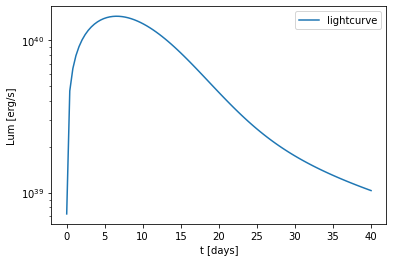

In [7]:
# Now we can plot our solution
plt.plot(t_list/day,Lum_list,label='lightcurve')

plt.xlabel('t [days]')
plt.ylabel('Lum [erg/s]')

plt.legend()
plt.semilogy()


Yay, lightcurve!

# For varying $M_0$, $E_0$,$R_0$ and $\kappa$

Let's figure out which parameter has the biggest impact on the ligthcurve!

In [8]:
# make the integration loop into a function, so we can run it for different parameters easily

def lc_cal(M0,E0,R0,kappa,label):
    
    v0 = np.sqrt(2*E0/M0)
    t_lc = (3./(4*np.pi) * (M0*kappa)/(c*v0)) **(1./2)
    print ('peak time ',t_lc/day)
    
    n = 100
    t_list = np.linspace(0.01,50,n)*day
    Lum_list = np.zeros(n)

    for i in range(n):

        t = t_list[i]
        eps_t = quad(integrand, 0, t, args=(t_lc,M0))[0]
        Lum_list[i] = kilonova_lc(t,t_lc,E0,R0,v0,eps_t)
     
    plt.plot(t_list/day,Lum_list,'--',label=label)


### Varying $M_0$, $E_0$ and$R_0$


peak time  8.183059145794253
peak time  13.762210203015021
peak time  8.183059145794253
peak time  6.881105101507511


Text(0, 0.5, 'Lum [erg/s]')

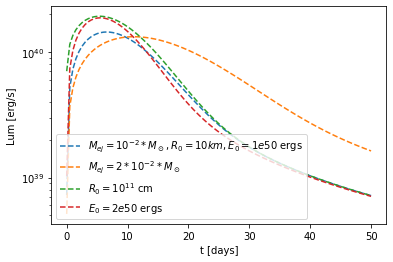

In [9]:
# Here we call the function from above
# The function variables for "lc_cal" are M0,E0,R0,kappa all in cgs and a label

# first our default parameters
lc_cal(1e-2*Mo,1e50,10*1e5,10.,r'$M_{ej} = 10^{-2}*M_\odot,R_0 = 10km,E_0 = 1e50$ ergs')

# then changing the mass 
lc_cal(2e-2*Mo,1e50,10**6,10.,r'$M_{ej} =2*10^{-2}*M_\odot$')

# changing the intial cloud size
lc_cal(1e-2*Mo,1e50,10**11,10.,r'$R_0 =10^{11}$ cm ')

# and chaning the explosion energy
lc_cal(1e-2*Mo,2e50,10*1e5,10.,r'$E_0 =2e50$ ergs')

plt.legend()
plt.semilogy()
plt.xlabel('t [days]')
plt.ylabel('Lum [erg/s]')

We don't actually know the amount of material ejected, but the lightcurve peak time changes  is depending on it. This is good news, as it means we can fit observations to ejecta mass!

Changing the energy has an effect on the peak luminosity.

Finally we have to change the size drastically to see an effect. Real changes in the ligtcurve are only seen when the intial size i close to the photosphere radius. 


### Varying $\kappa$

The kilonova that has been seen, had a blue and a red part. 
We think this is coursed by two different ejections of material, which had different electron fractions and therefore different compositions and different opacities.

peak time  2.5877105128581706
peak time  8.183059145794253


Text(0, 0.5, 'Lum [erg/s]')

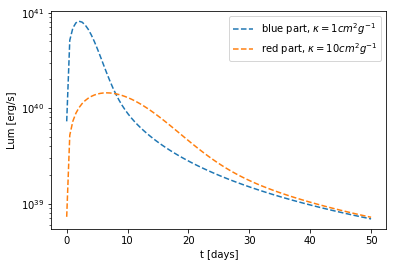

In [10]:
# Here we call the function from above again,
# This time we vary the last important parameter ka
lc_cal(1e-2*Mo,1e50,10*1e5,1.,r'blue part, $\kappa = 1 cm^2 g^{-1}$')
lc_cal(1e-2*Mo,1e50,10*1e5,10.,r'red part, $\kappa = 10 cm^2 g^{-1}$')


plt.legend()
plt.semilogy()
plt.xlabel('t [days]')
plt.ylabel('Lum [erg/s]')